# Initialization
This project assumes data is stored in Google Cloud Storage, and that GitHub and Google Cloud Storage info is stored in environmental variables.  
It was developed in Google Colab, but can be run locally by selecting 'local' as the environment.  

For setup details (including required environment variables), see the README.md in the GitHub repository:  
https://github.com/tristan-day-research/NeuroStorm_seizure_detection  

In [1]:
# --- SETUP GITHUB AND GCP ENVIRONMENT VARIABLES ---
# Ensure the following environmental variables are set in Colab user data:
# - GITHUB_PAT: GitHub Personal Access Token
# - GITHUB_EMAIL: GitHub email for commits
# - GITHUB_USER_NAME: GitHub username
# - GCP_EEG_PROJECT_ID: Google Cloud Project ID
# - GCP_EEG_BUCKET_NAME: (Optional) GCP bucket for EEG data

# Select environment
ENVIRONMENT = 'colab'   # Choose 'local' or 'colab'
BRANCH_NAME = 'main'

if ENVIRONMENT == 'colab':
    from google.colab import userdata

    # Retrieve GitHub credentials from Colab user data
    token = userdata.get('GITHUB_PAT')
    github_email = userdata.get('GITHUB_EMAIL')
    github_username = userdata.get('GITHUB_USER_NAME')

    # Clone the repository (done here as the helper file isn't available yet)
    !git clone -b {BRANCH_NAME} https://{token}@github.com/tristan-day-research/NeuroStorm_seizure_detection.git

    # Change to correct directory
    %cd /content/NeuroStorm_seizure_detection/

    # Load the helper file now that the repo is cloned
    from src.setup import configure_environment

    # Run full environment setup
    gcp_bucket_name, gcp_file_prefix, project_id = configure_environment(environment=ENVIRONMENT)


Cloning into 'NeuroStorm_seizure_detection'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 244 (delta 32), reused 63 (delta 31), pack-reused 180 (from 1)
Receiving objects: 100% (244/244), 6.91 MiB | 14.78 MiB/s, done.
Resolving deltas: 100% (115/115), done.
/content/NeuroStorm_seizure_detection
GCP Project Set
Git configured with your user data.


In [2]:
# Standard Library Imports
import os
import gc
import json
import time
import glob
import math
import random
import threading
import subprocess
import logging
from collections import OrderedDict
from datetime import datetime
from functools import partial
from warnings import warn

# Third-Party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams["font.family"] = "serif"
from tqdm import tqdm

# Machine Learning/Deep Learning Imports
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.nn.init import trunc_normal_
from torch.nn.utils import clip_grad_norm_, rnn
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast
from torchvision.transforms import Compose

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
!nvidia-smi

Using device: cpu
/bin/bash: line 1: nvidia-smi: command not found


# Preprocessing
Each EEG raw signal is segemnted into patches of a fixed length. Fast Fourier Transform (FFT) spectra are made from these patches which will be used to train the Vector-Quantized Variational Autoencoder (VQ-VAE). The raw files will be loaded from a Google Cloud Platform bucket asynchronously during trainig, so data processing and model training can be done concurrantly.

The source code is in src/data_and_FFT.py. The following code block is simply to test the data loading, patch creation, and FFT. It will visualize a few samples for both raw EEG signal and the corresponding FFT.

Gathering data from /train_eegs
Found 17300 files. Visualizing...
Raw EEG Shape: torch.Size([66, 200, 20])
FFT Data Shape: torch.Size([66, 129, 20])


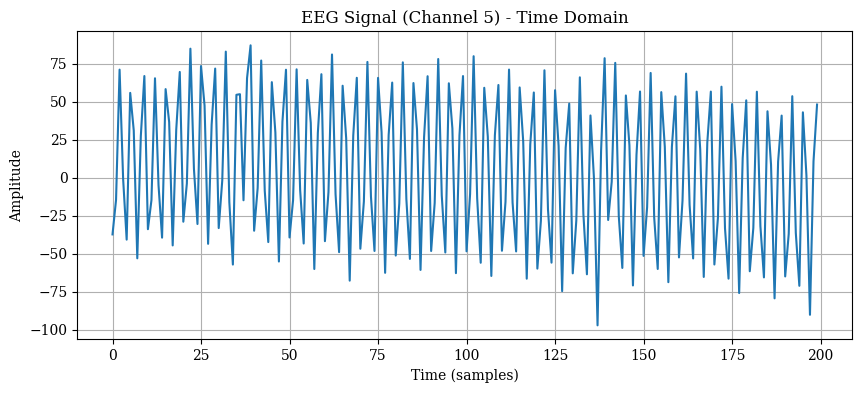

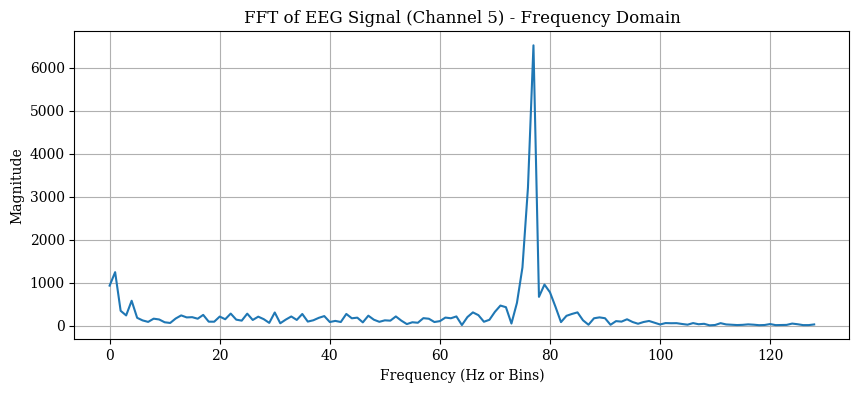

Raw EEG Shape: torch.Size([74, 200, 20])
FFT Data Shape: torch.Size([74, 129, 20])


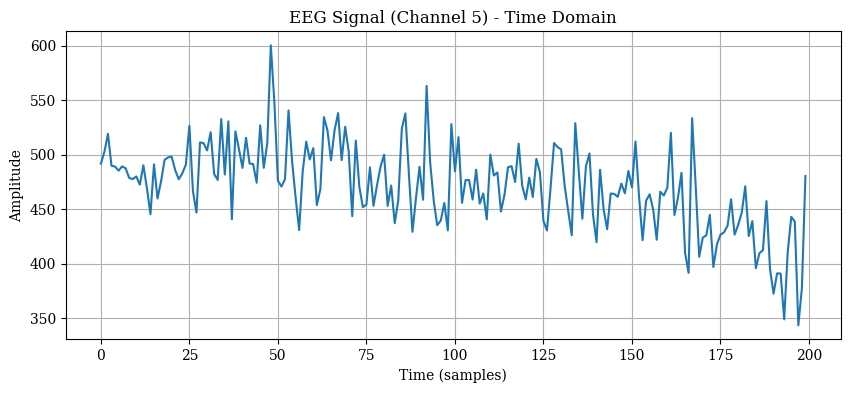

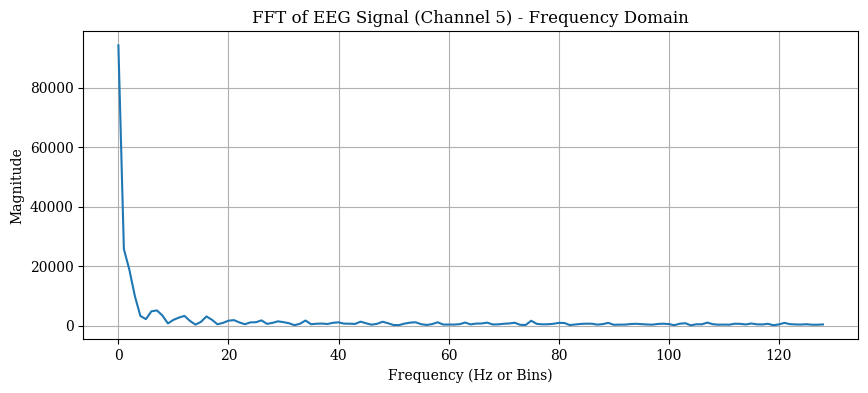

Raw EEG Shape: torch.Size([77, 200, 20])
FFT Data Shape: torch.Size([77, 129, 20])


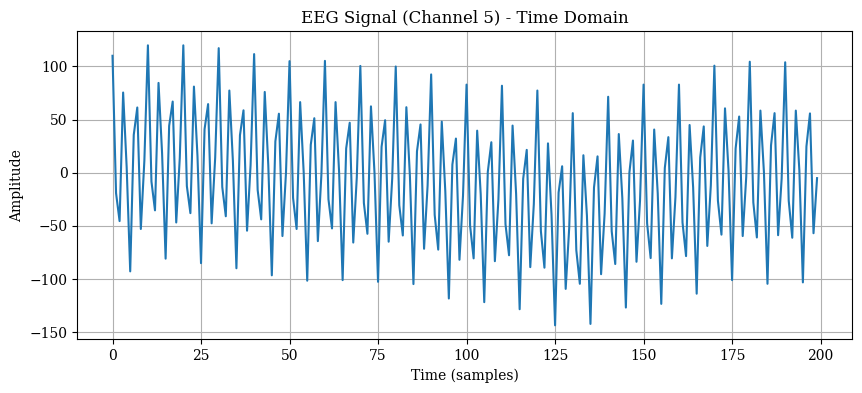

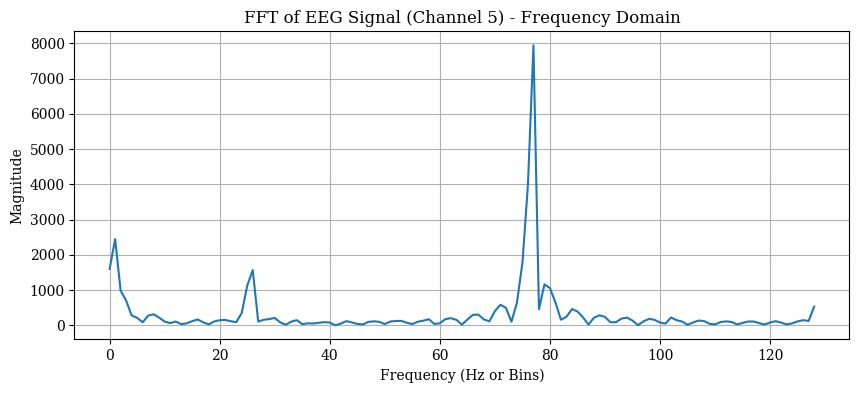

Raw EEG Shape: torch.Size([271, 200, 20])
FFT Data Shape: torch.Size([271, 129, 20])


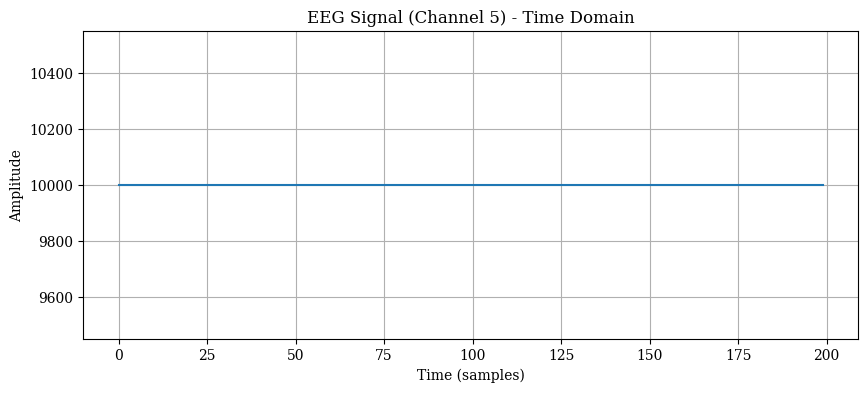

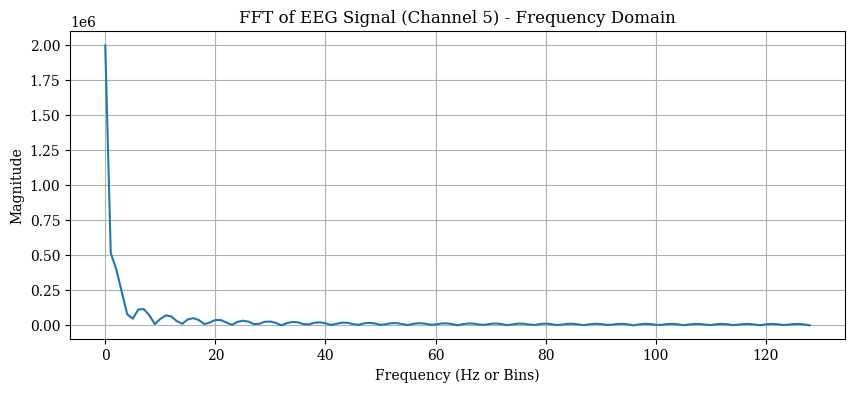

Raw EEG Shape: torch.Size([327, 200, 20])
FFT Data Shape: torch.Size([327, 129, 20])


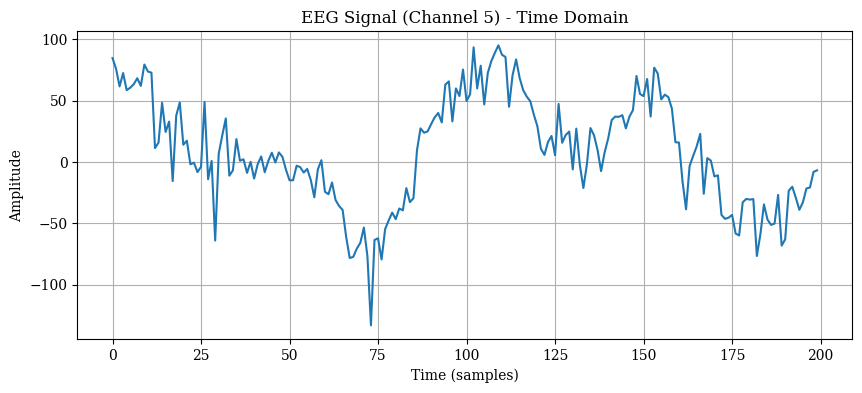

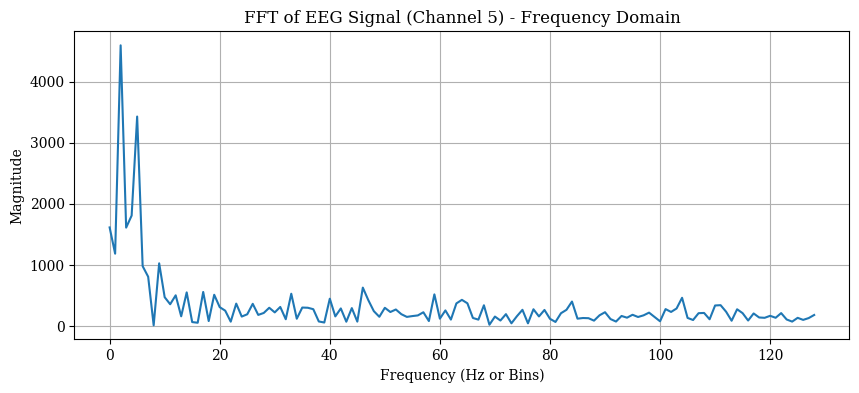

Raw EEG Shape: torch.Size([119, 200, 20])
FFT Data Shape: torch.Size([119, 129, 20])


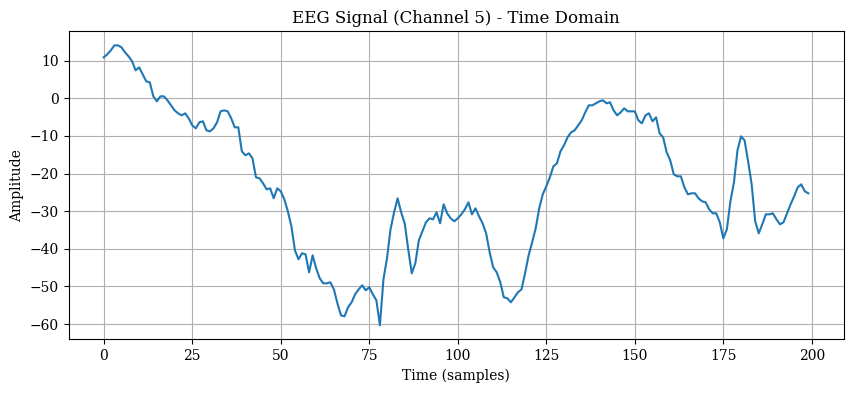

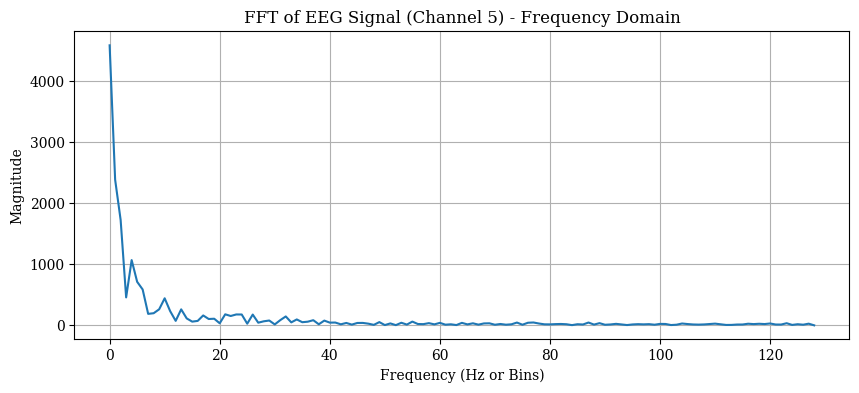

Raw EEG Shape: torch.Size([87, 200, 20])
FFT Data Shape: torch.Size([87, 129, 20])


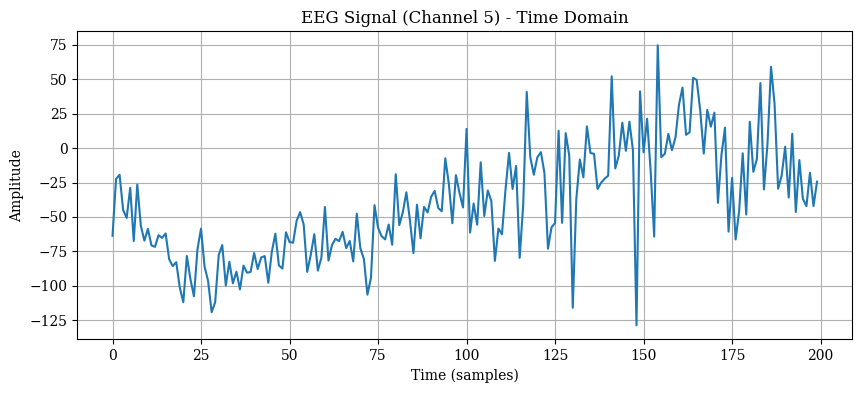

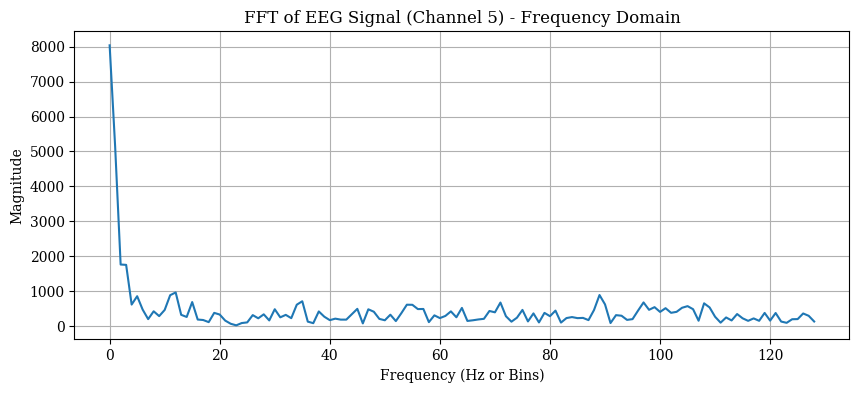

Raw EEG Shape: torch.Size([82, 200, 20])
FFT Data Shape: torch.Size([82, 129, 20])


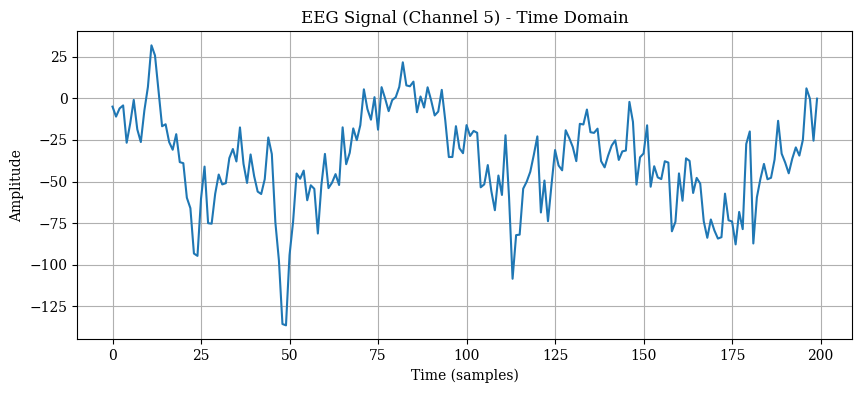

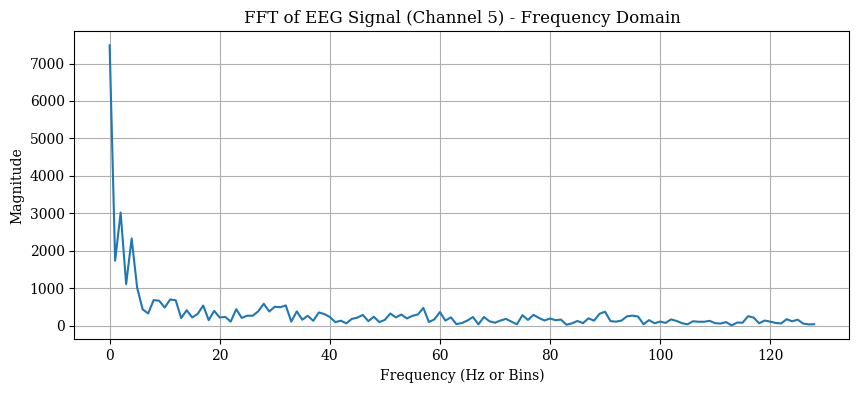

Raw EEG Shape: torch.Size([66, 200, 20])
FFT Data Shape: torch.Size([66, 129, 20])


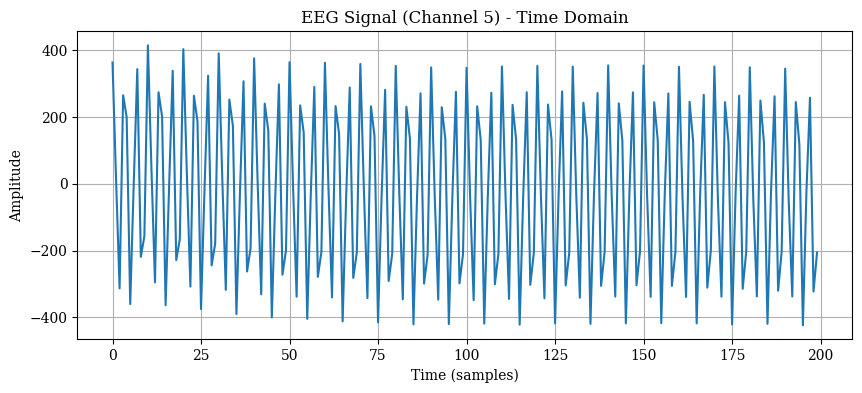

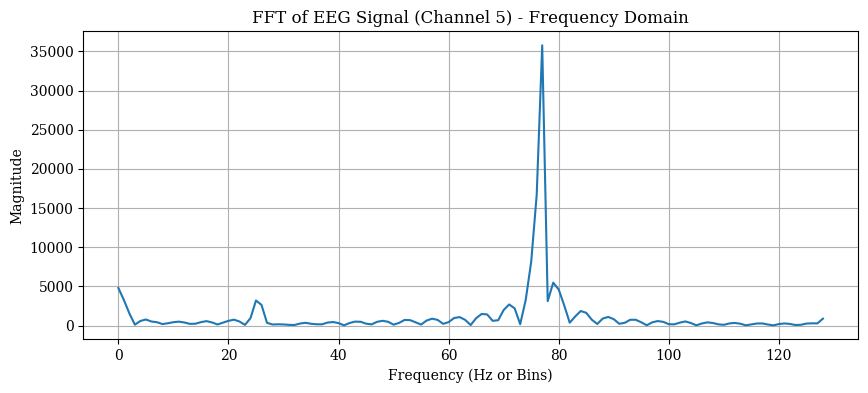

Raw EEG Shape: torch.Size([626, 200, 20])
FFT Data Shape: torch.Size([626, 129, 20])


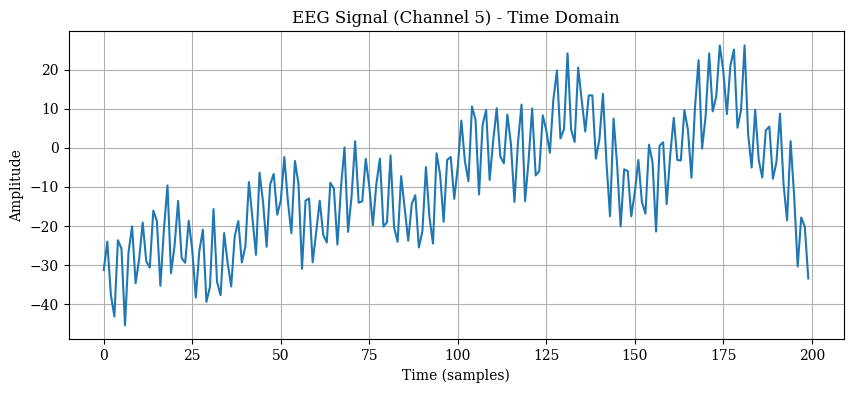

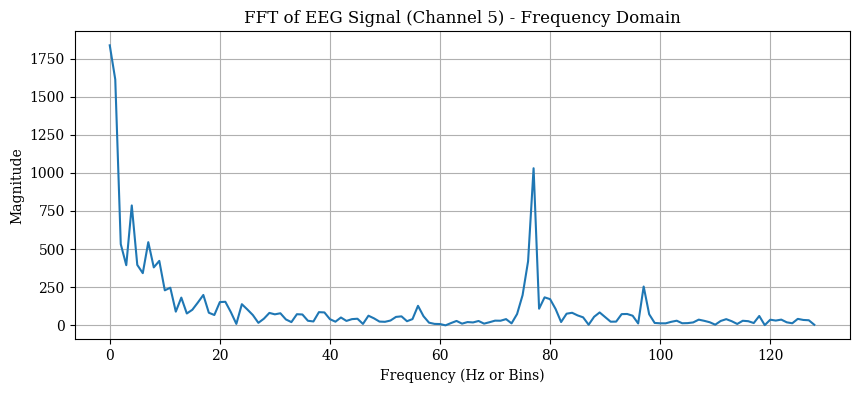

Raw EEG Shape: torch.Size([111, 200, 20])
FFT Data Shape: torch.Size([111, 129, 20])


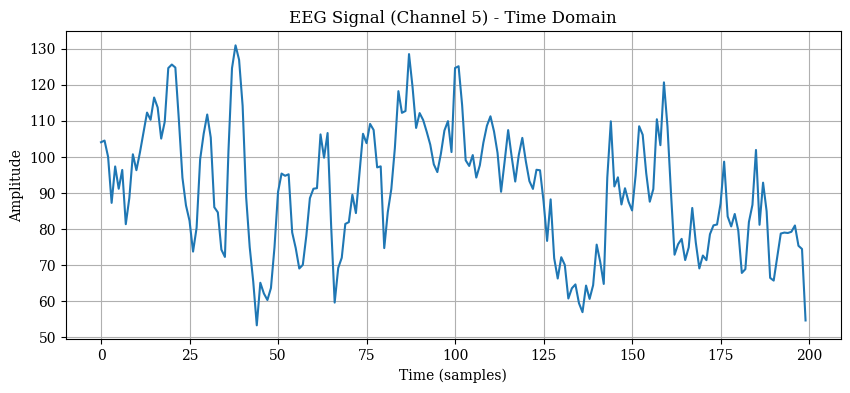

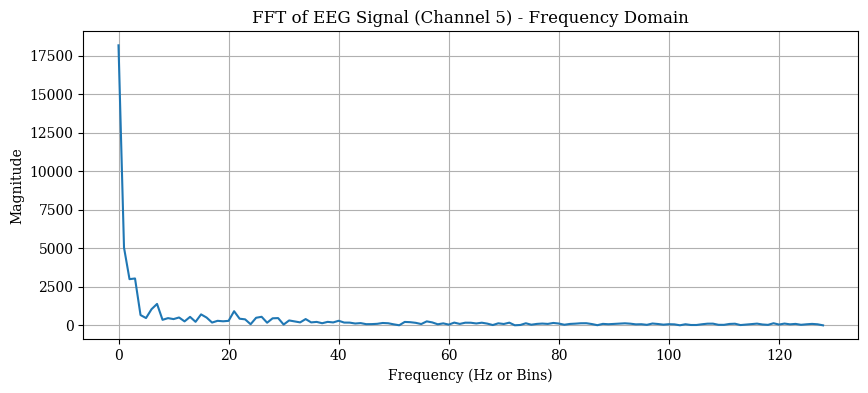

Raw EEG Shape: torch.Size([223, 200, 20])
FFT Data Shape: torch.Size([223, 129, 20])


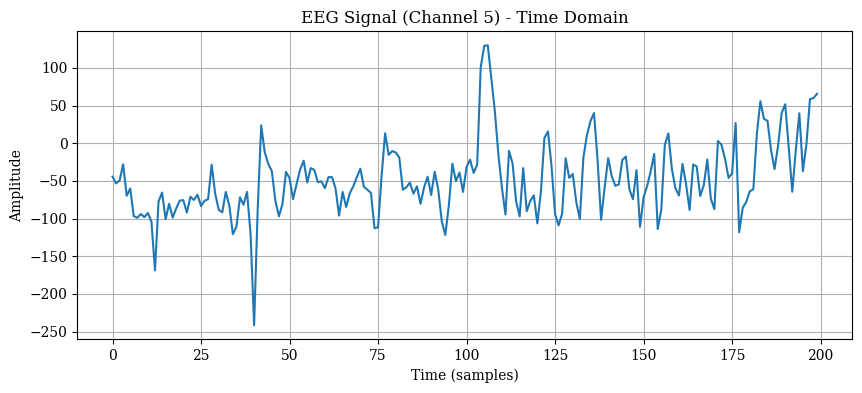

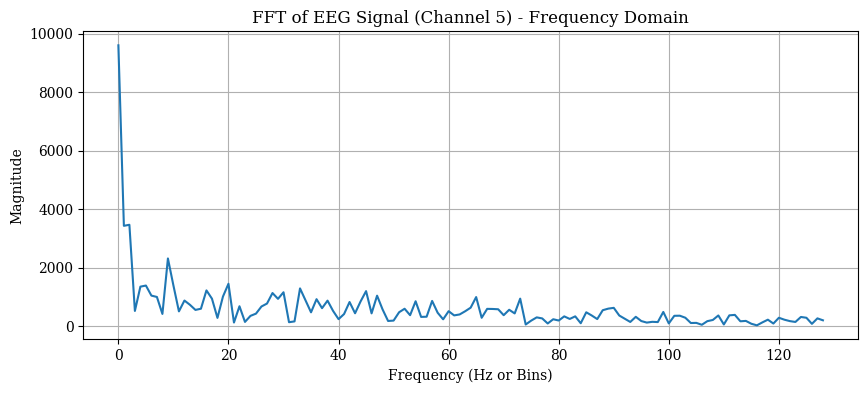

Raw EEG Shape: torch.Size([66, 200, 20])
FFT Data Shape: torch.Size([66, 129, 20])


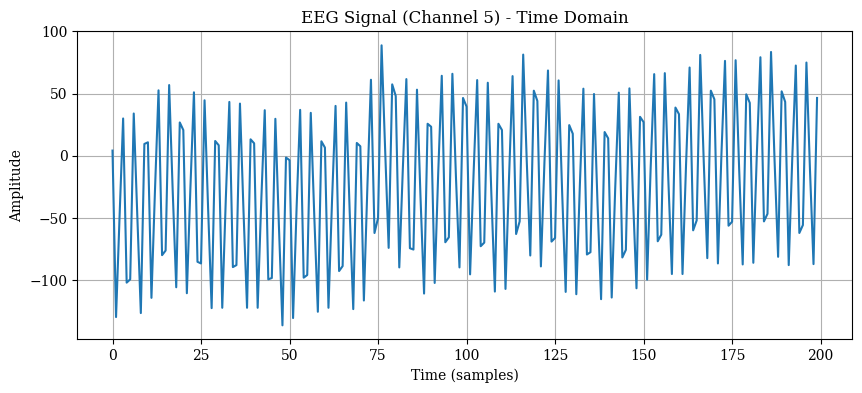

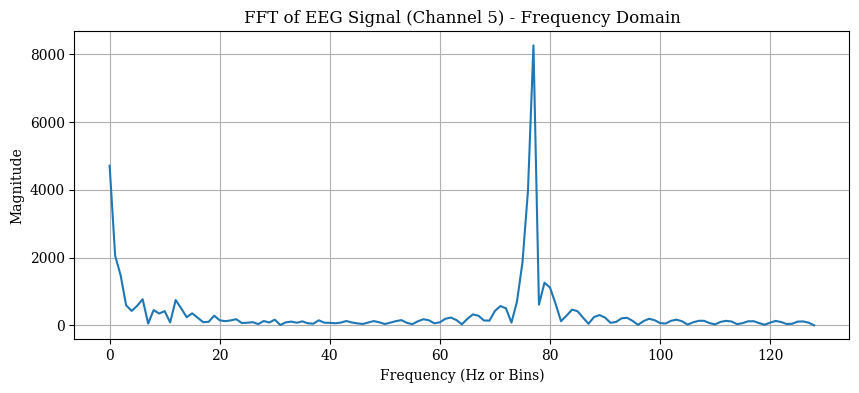

Raw EEG Shape: torch.Size([66, 200, 20])
FFT Data Shape: torch.Size([66, 129, 20])


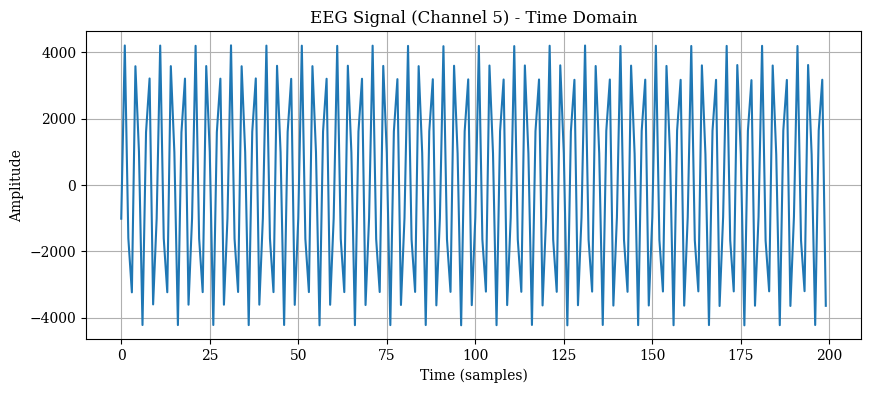

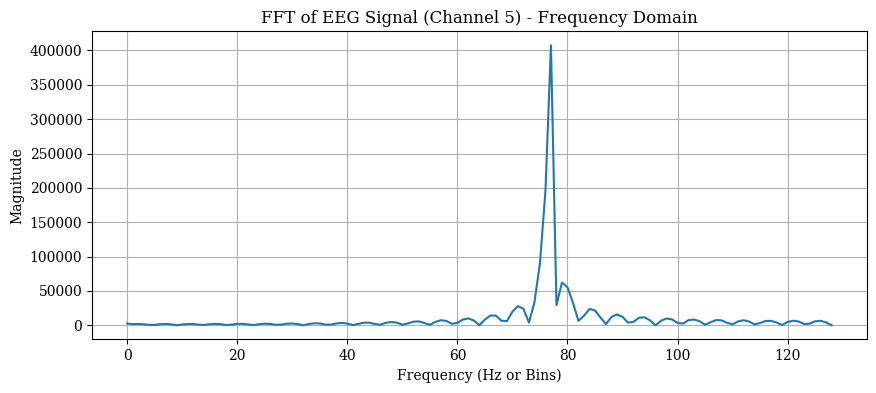

Raw EEG Shape: torch.Size([74, 200, 20])
FFT Data Shape: torch.Size([74, 129, 20])


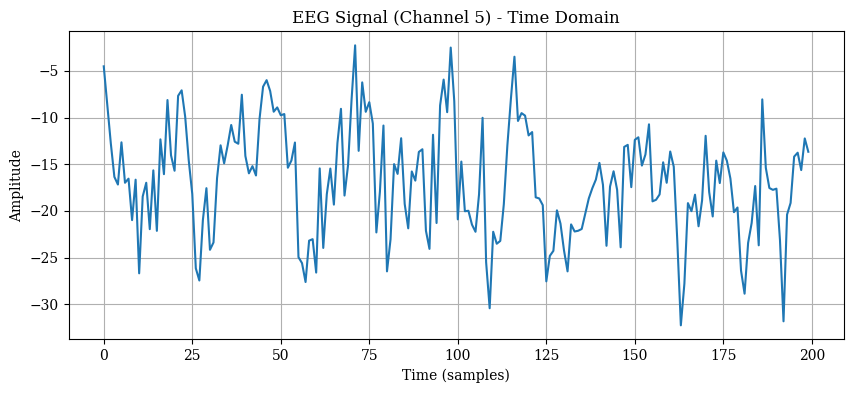

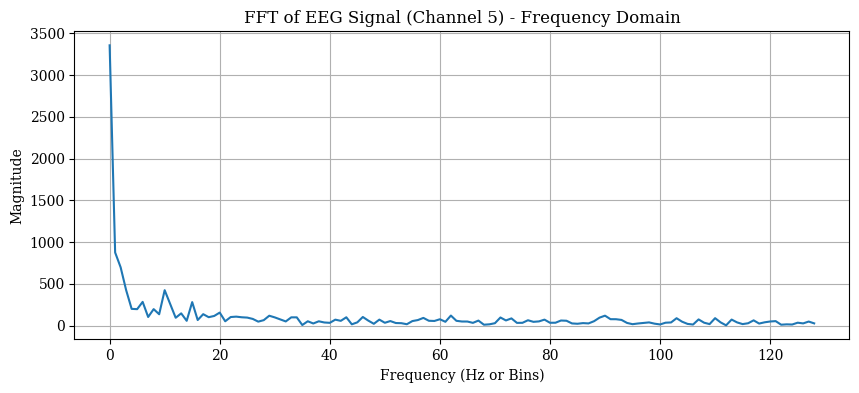

Raw EEG Shape: torch.Size([87, 200, 20])
FFT Data Shape: torch.Size([87, 129, 20])


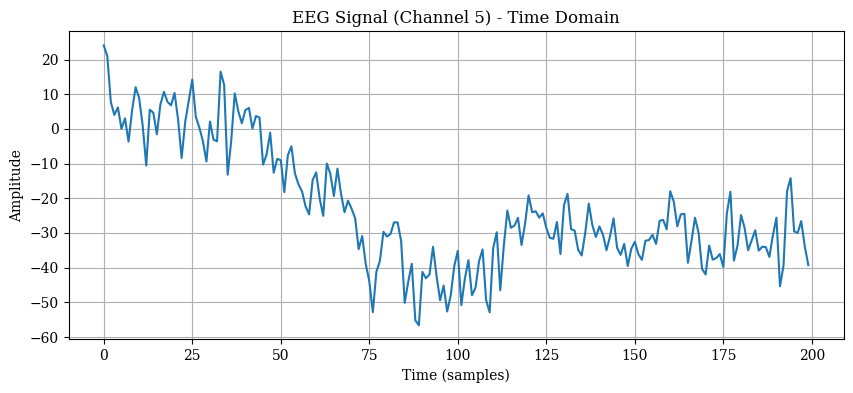

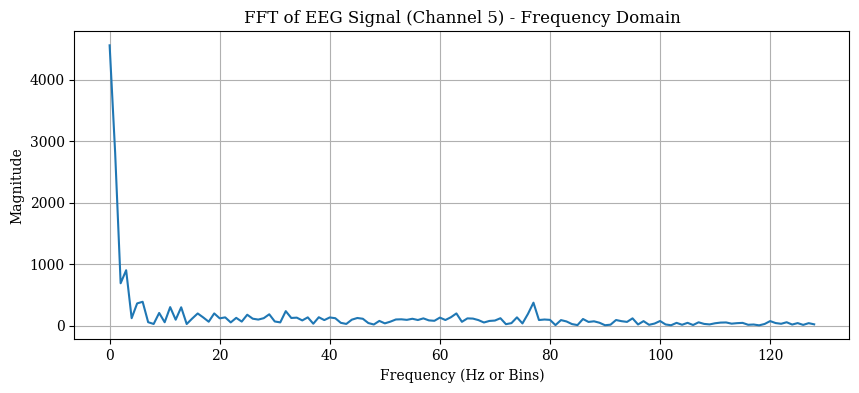

Raw EEG Shape: torch.Size([74, 200, 20])
FFT Data Shape: torch.Size([74, 129, 20])


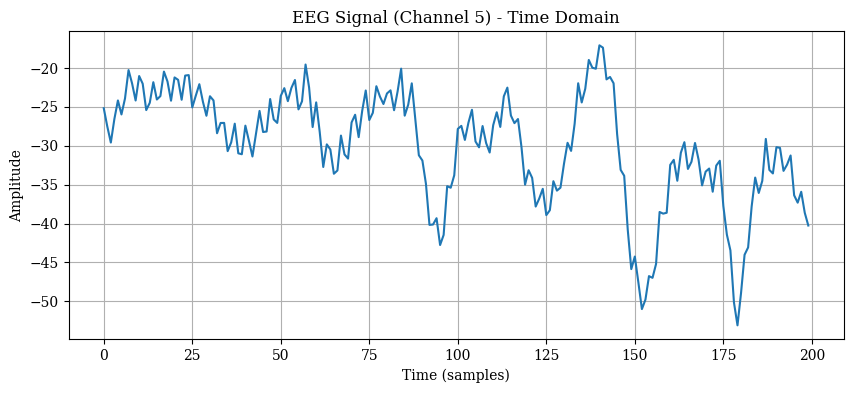

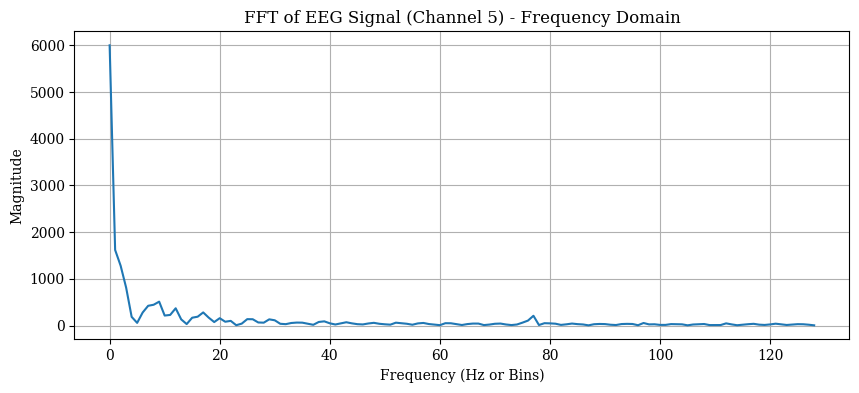

Raw EEG Shape: torch.Size([74, 200, 20])
FFT Data Shape: torch.Size([74, 129, 20])


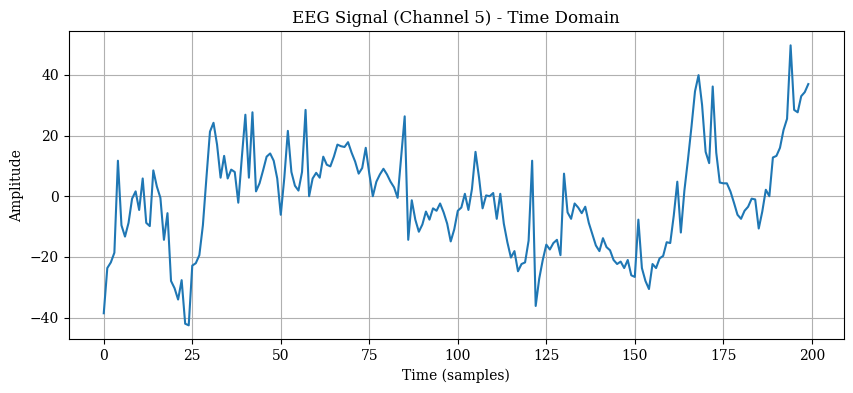

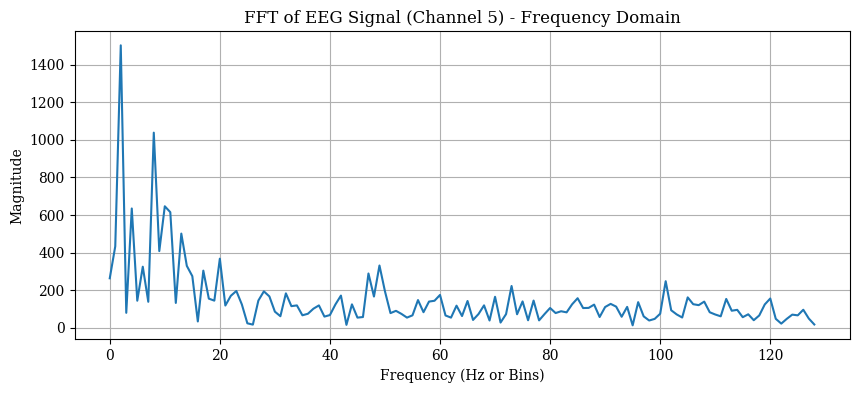

Raw EEG Shape: torch.Size([79, 200, 20])
FFT Data Shape: torch.Size([79, 129, 20])


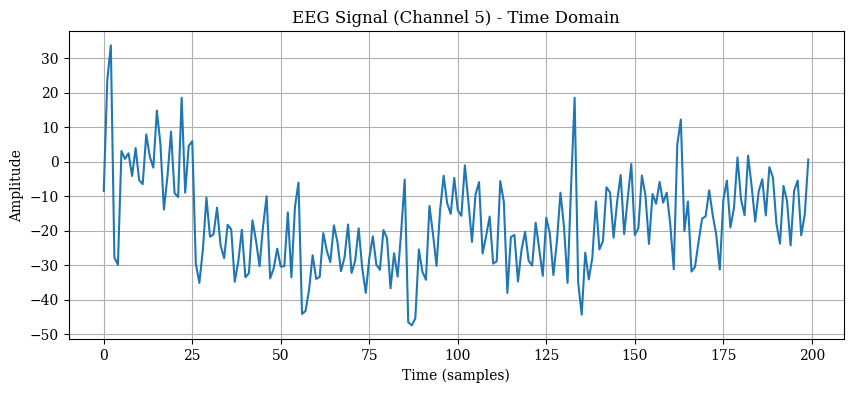

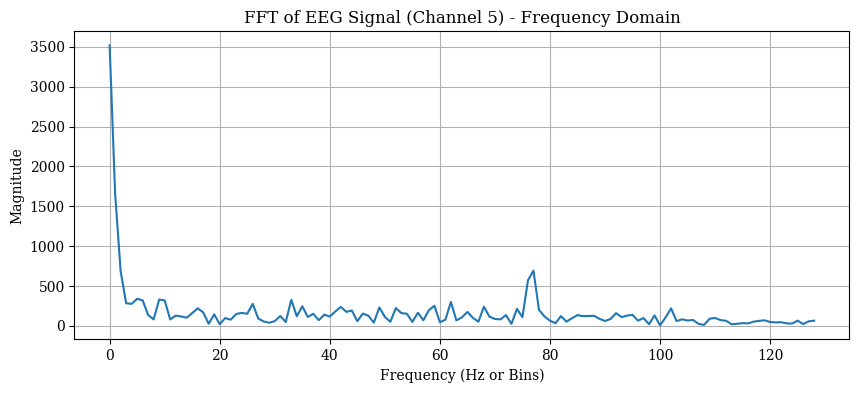

Raw EEG Shape: torch.Size([71, 200, 20])
FFT Data Shape: torch.Size([71, 129, 20])


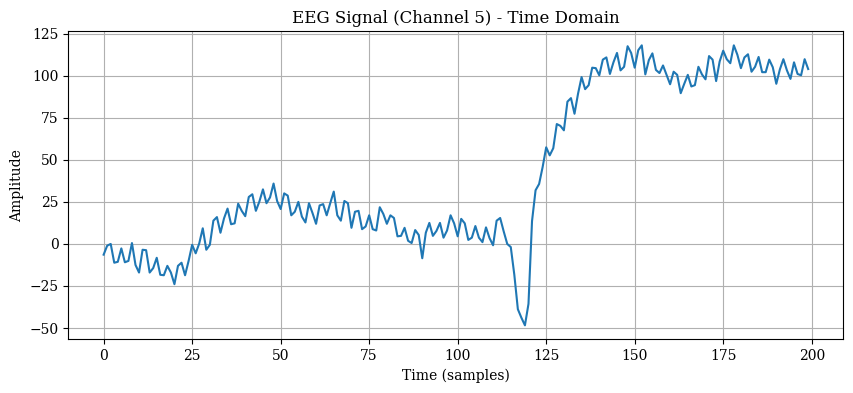

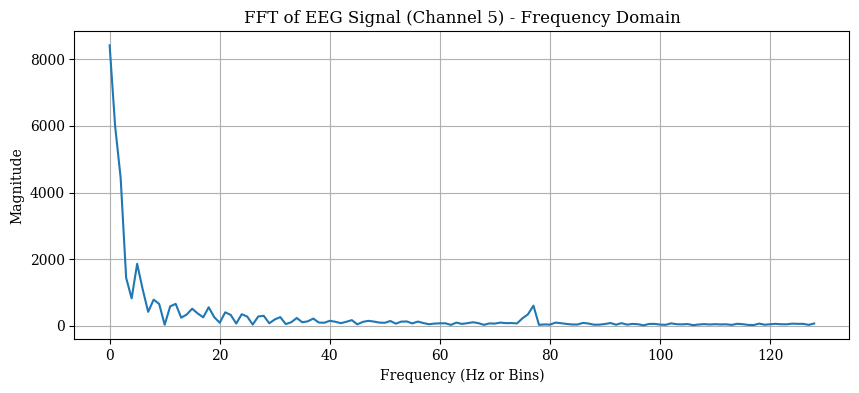

Raw EEG Shape: torch.Size([170, 200, 20])
FFT Data Shape: torch.Size([170, 129, 20])


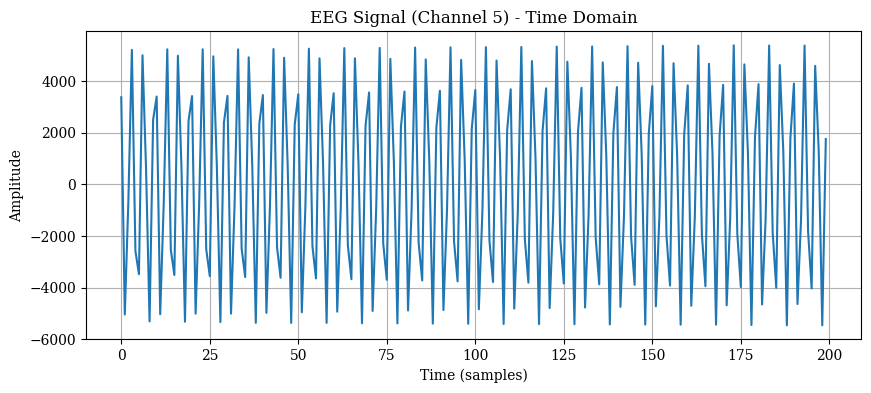

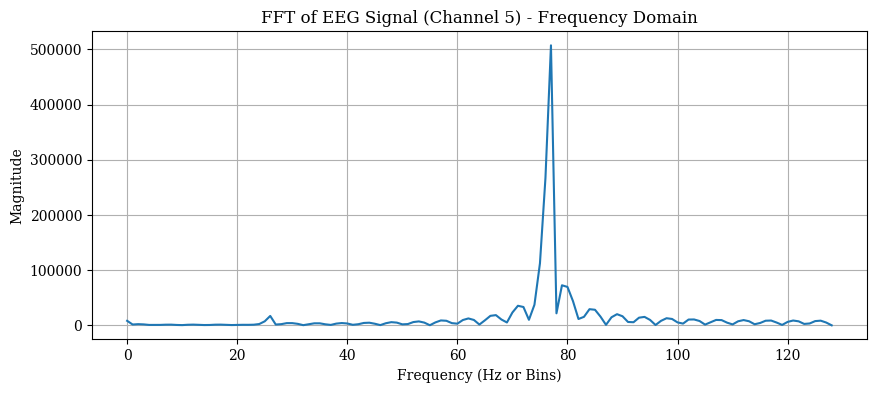

Raw EEG Shape: torch.Size([103, 200, 20])
FFT Data Shape: torch.Size([103, 129, 20])


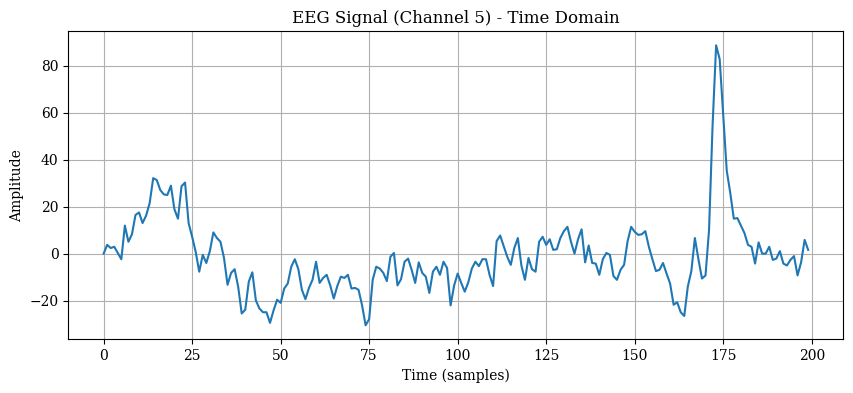

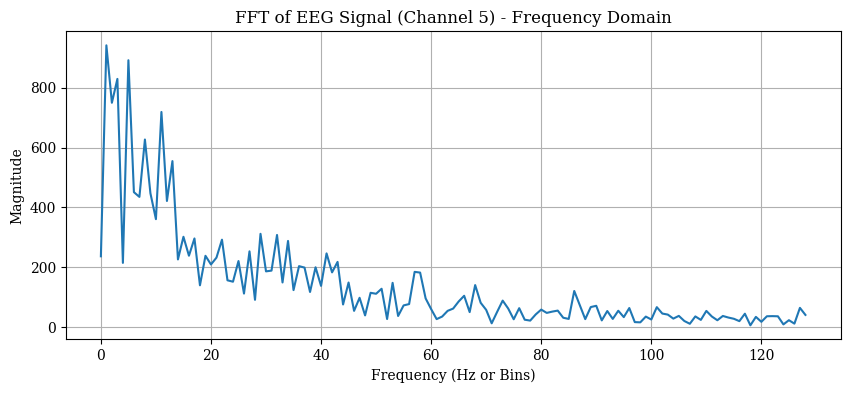

Raw EEG Shape: torch.Size([93, 200, 20])
FFT Data Shape: torch.Size([93, 129, 20])


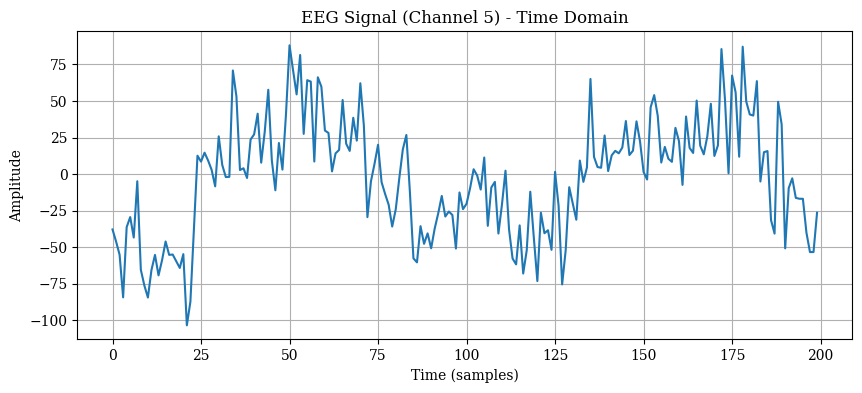

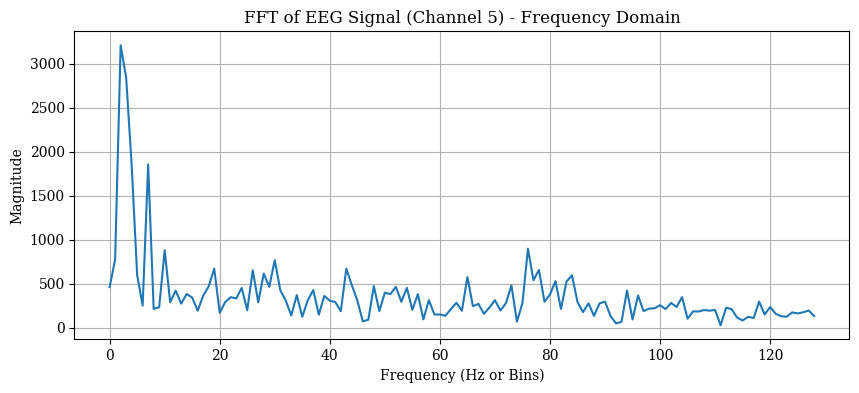

Raw EEG Shape: torch.Size([114, 200, 20])
FFT Data Shape: torch.Size([114, 129, 20])


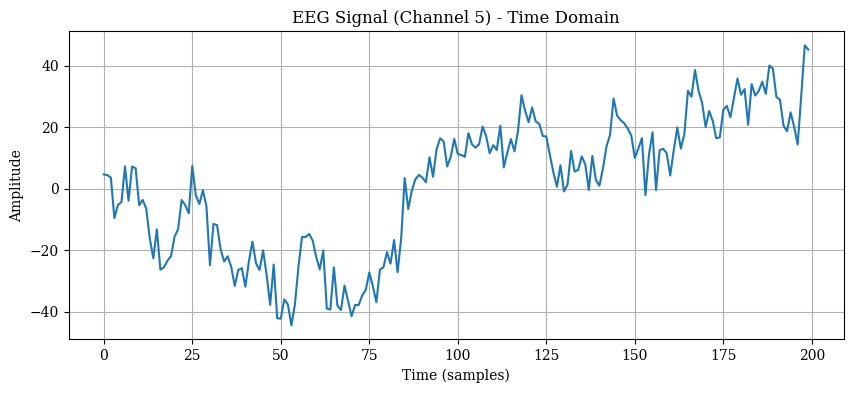

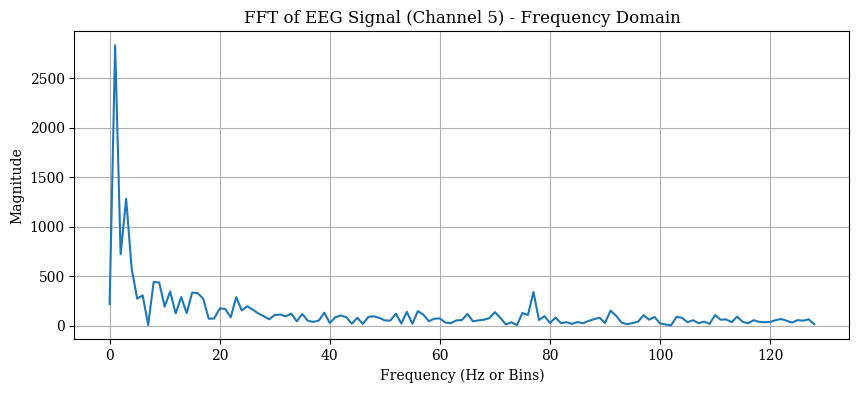

Raw EEG Shape: torch.Size([125, 200, 20])
FFT Data Shape: torch.Size([125, 129, 20])


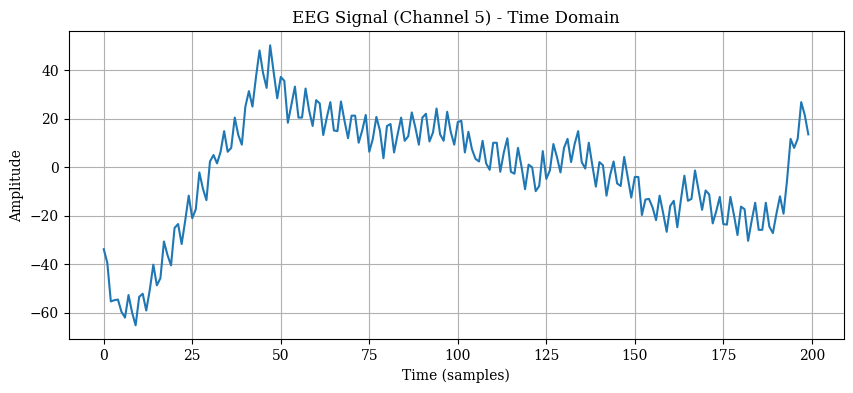

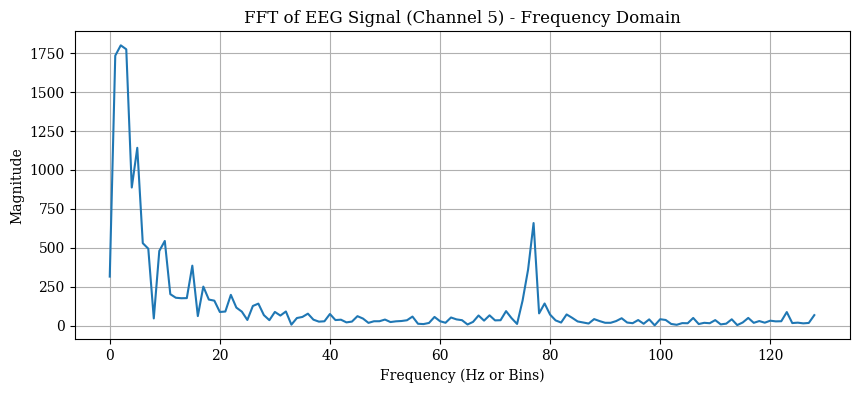

Raw EEG Shape: torch.Size([247, 200, 20])
FFT Data Shape: torch.Size([247, 129, 20])


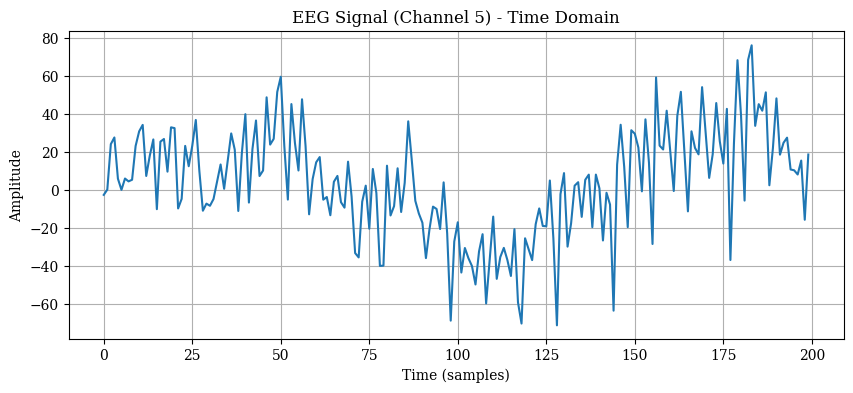

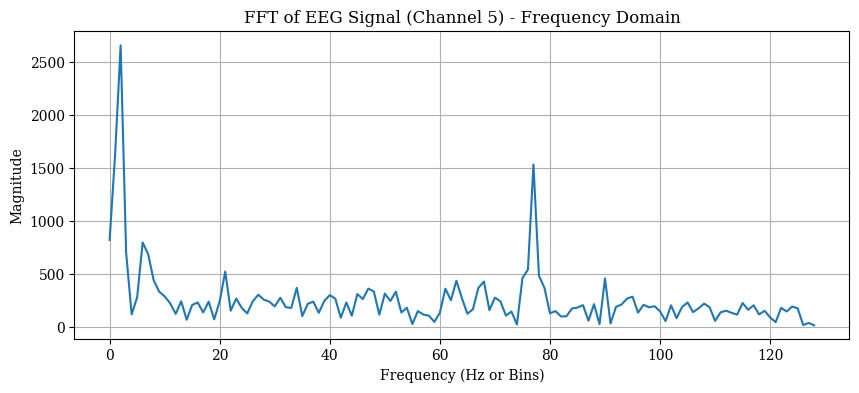

Raw EEG Shape: torch.Size([66, 200, 20])
FFT Data Shape: torch.Size([66, 129, 20])


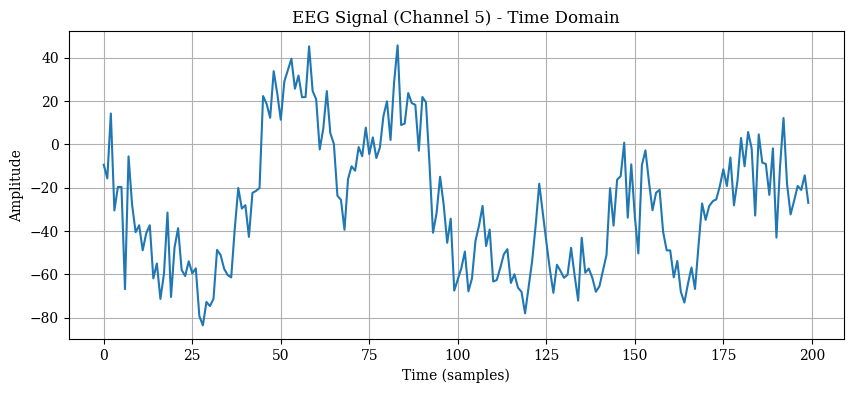

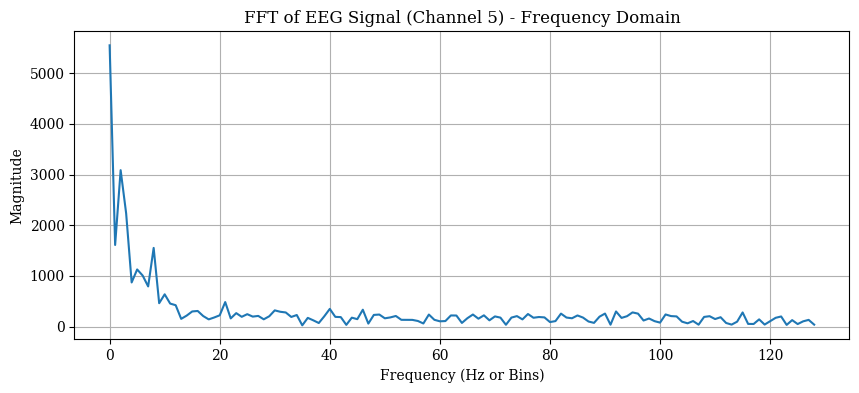

Raw EEG Shape: torch.Size([175, 200, 20])
FFT Data Shape: torch.Size([175, 129, 20])


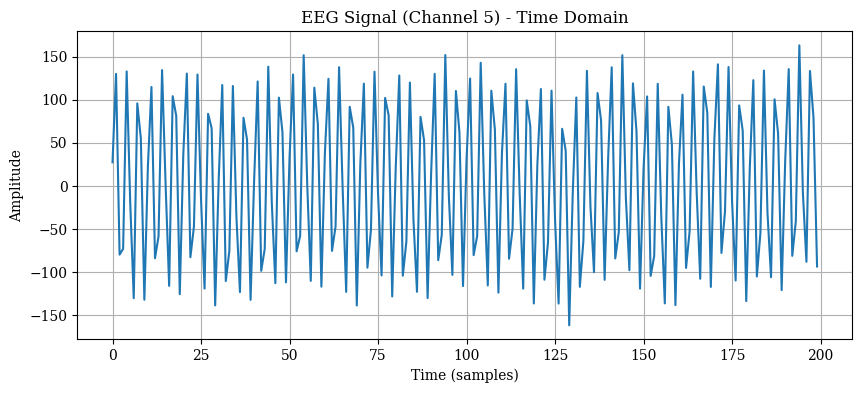

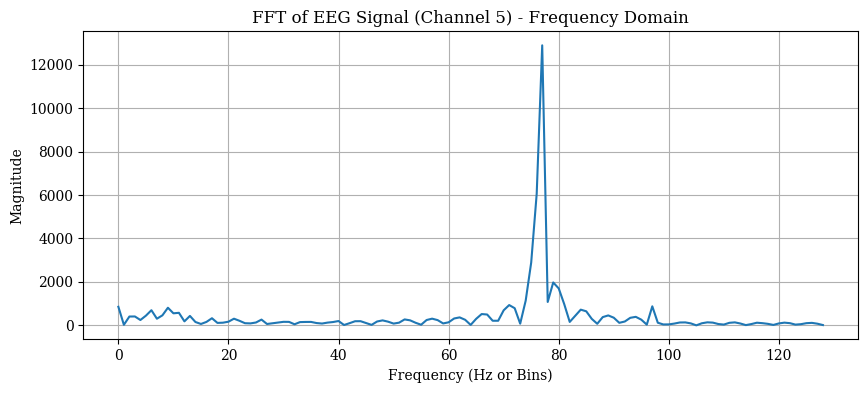

Raw EEG Shape: torch.Size([66, 200, 20])
FFT Data Shape: torch.Size([66, 129, 20])


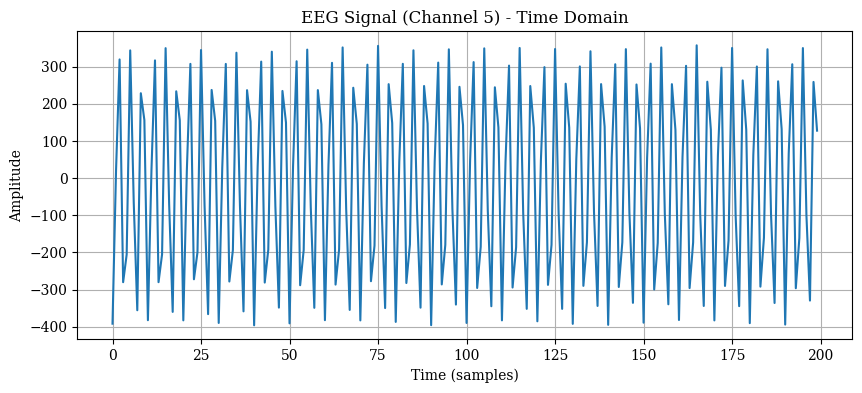

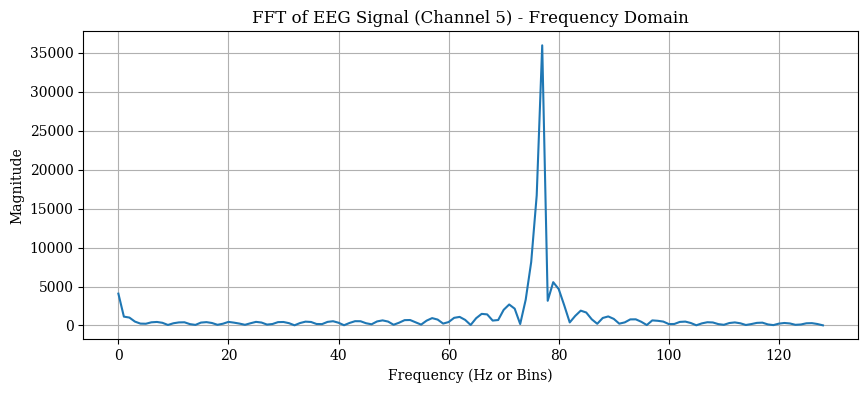

Raw EEG Shape: torch.Size([122, 200, 20])
FFT Data Shape: torch.Size([122, 129, 20])


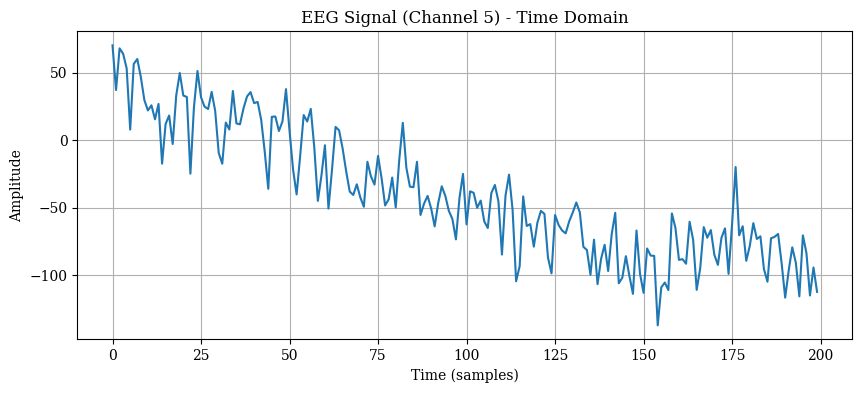

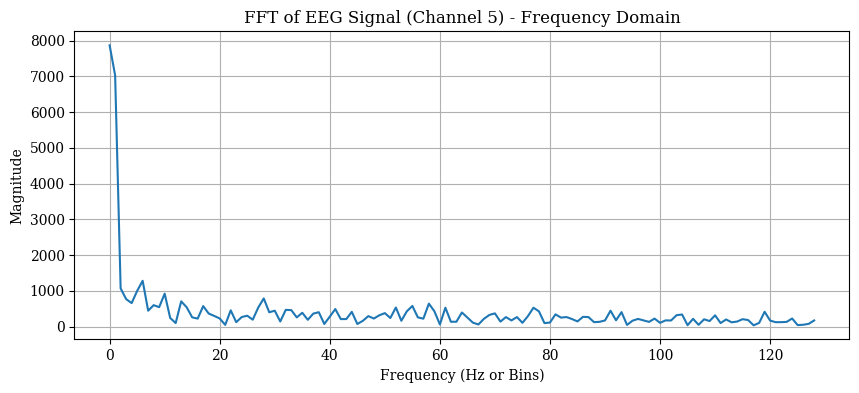

Raw EEG Shape: torch.Size([165, 200, 20])
FFT Data Shape: torch.Size([165, 129, 20])


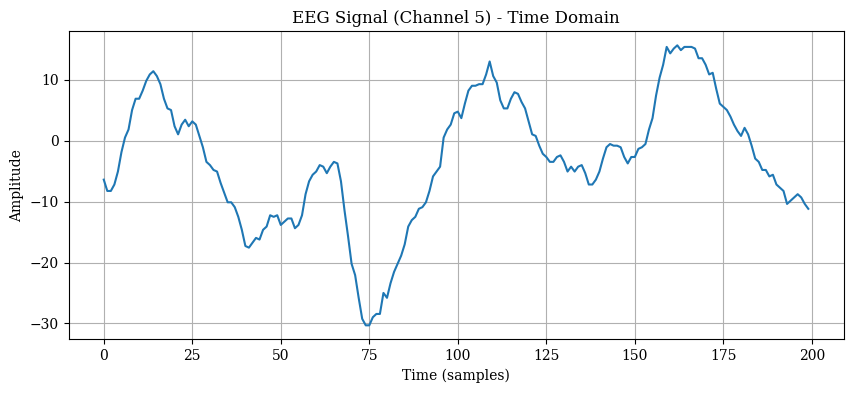

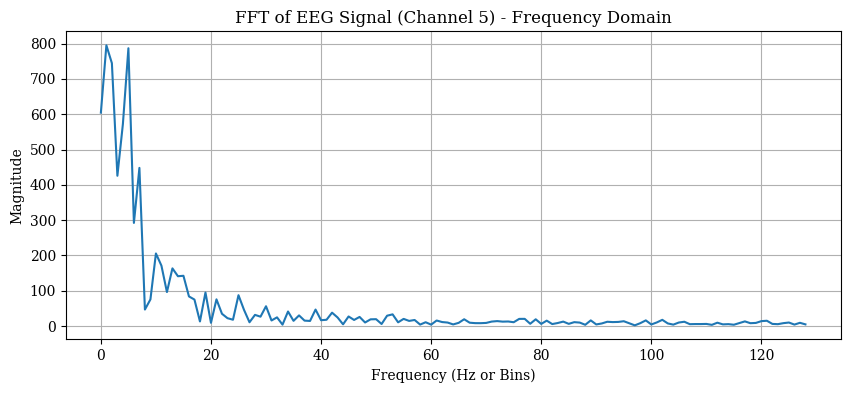

Raw EEG Shape: torch.Size([66, 200, 20])
FFT Data Shape: torch.Size([66, 129, 20])


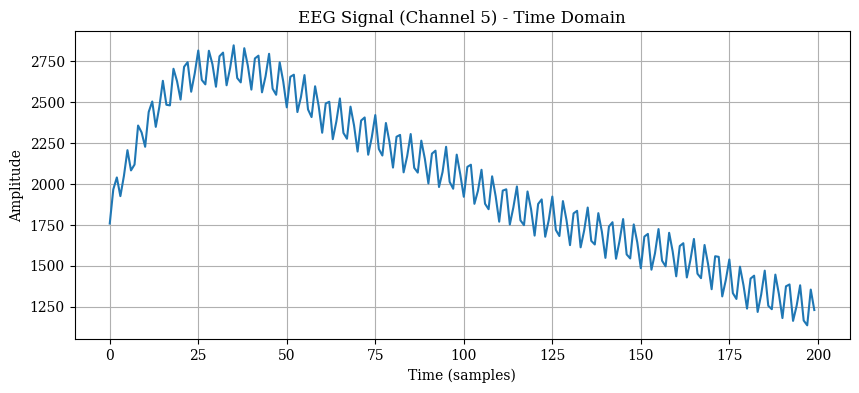

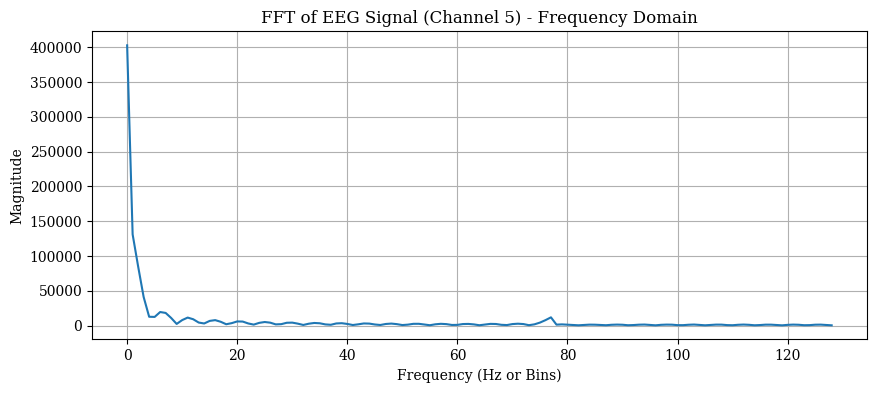

Raw EEG Shape: torch.Size([66, 200, 20])
FFT Data Shape: torch.Size([66, 129, 20])


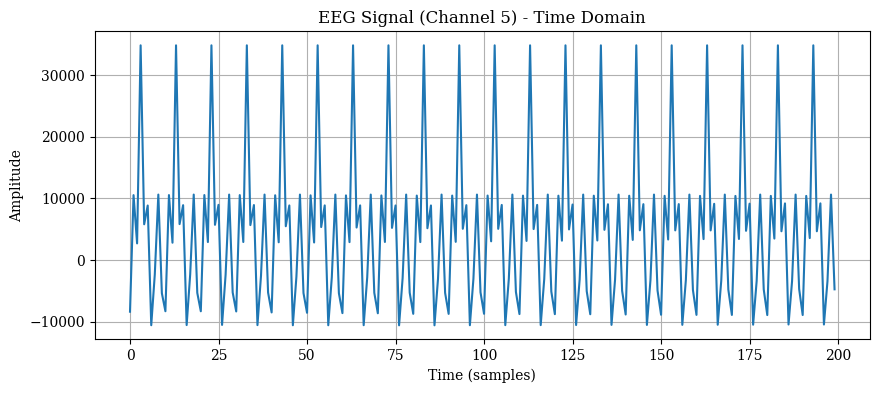

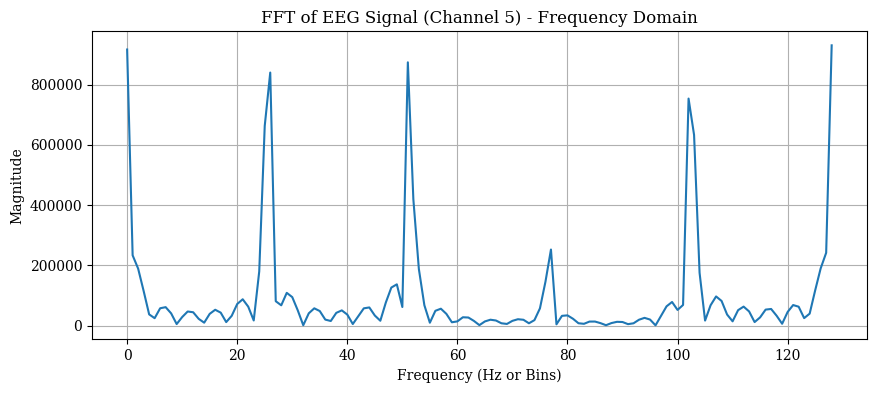

In [ ]:
# gcp_filepath and gcp_bucket_name are environmental variable that are defined in setup.py

from src.data_and_FFT import EEGDataset, visualize_eeg, visualize_fft

import importlib
from src import data_and_FFT

# Force reload of the module
importlib.reload(data_and_FFT)

# Now import the class or functions
from src.data_and_FFT import EEGDataset, visualize_eeg, visualize_fft

# Parameters
patch_size = 200
overlap = 50
fft_size = 256
data_dir = '/train_eegs'
channel = 5
sample_idx = 7

# Append the data_dir to the GCP file path prefix
gcp_file_path = gcp_file_prefix.rstrip('/') + data_dir
print(f"Gathering data from {data_dir}")


# Load Dataset and Visualize
def load_and_visualize_samples(bucket_name, gcp_file_path, patch_size, overlap, fft_size):
    dataset = EEGDataset(
        bucket_name=gcp_bucket_name,
        gcp_file_path=gcp_file_path,
        patch_size=patch_size,
        overlap=overlap,
        fft_size=fft_size
    )

    print(f"Found {len(dataset)} files. Visualizing...")

    for i in range(min(33, len(dataset))):  # Visualize 3 samples or fewer
        # fft_data, mask = dataset[i]

        # Load a sample (returns raw EEG and FFT)
        raw_eeg, fft_data, mask = dataset[i]

        print("Raw EEG Shape:", raw_eeg.shape)  # [num_patches, patch_size, channels]
        print("FFT Data Shape:", fft_data.shape)  # [num_patches, fft_size // 2 + 1, channels]

        # Visualize the 0th patch, 0th channel

        # Visualize raw EEG (time domain)
        visualize_eeg(raw_eeg, sample_idx=sample_idx, channel=channel)

        # Visualize FFT (frequency domain)
        visualize_fft(fft_data, fft_size=256, sample_idx=sample_idx, channel=channel)


# Run Test
load_and_visualize_samples(
    bucket_name=gcp_bucket_name,
    gcp_file_path=gcp_file_path,
    patch_size=patch_size,
    overlap=overlap,
    fft_size=fft_size
)


In [ ]:
from torch.utils.data import DataLoader

# from src.data_and_FFT import EEGDataset, visualize_eeg, visualize_fft, custom_collate

import importlib
from src import data_and_FFT

# Force reload of the module
importlib.reload(data_and_FFT)

# Now import the class or functions
from src.data_and_FFT import EEGDataset, visualize_eeg, visualize_fft, custom_collate


# Parameters
patch_size = 200
overlap = 50
fft_size = 256

dataloader = DataLoader(
    EEGDataset(gcp_bucket_name, gcp_file_path, patch_size=200, overlap=50, fft_size=256),
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=custom_collate  # Pass the custom collate function here
)


import time

start = time.time()
for i, (eeg_patches, fft_data, mask) in enumerate(dataloader):
    if i == 5:  # Simulate loading 5 batches
        break
end = time.time()

print(f"Time to load 5 batches: {end - start:.2f} seconds")


Time to load 5 batches: 37.78 seconds


## EDA for FFT magnitude and frequency distribution.
FFT normalizaiton can be performed per sample or per batch. The choice depends on how consistant the EEG samples and FFTs are. This is to explore that.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7822e8126d40>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7822e8126d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

    if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: can only test a child processif w.is_alive():

Exception ignored

Total zero elements in FFT: 309595694
Total NaN elements in FFT: 0


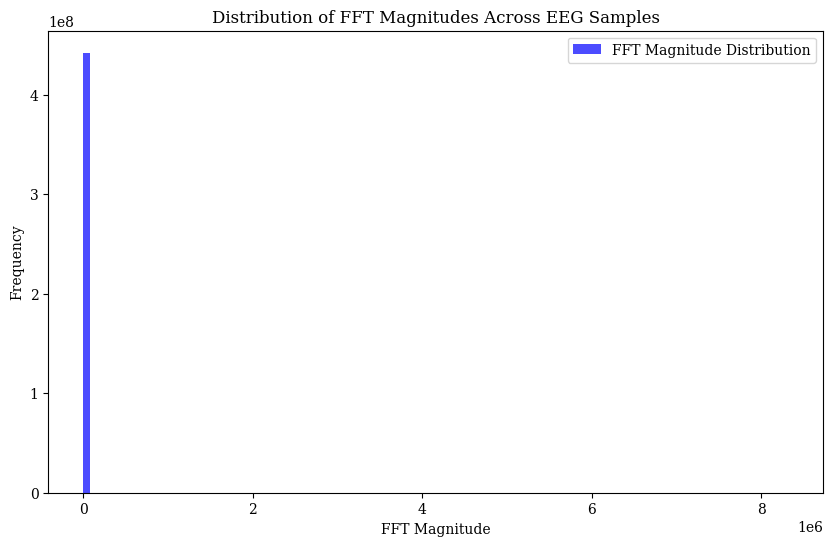

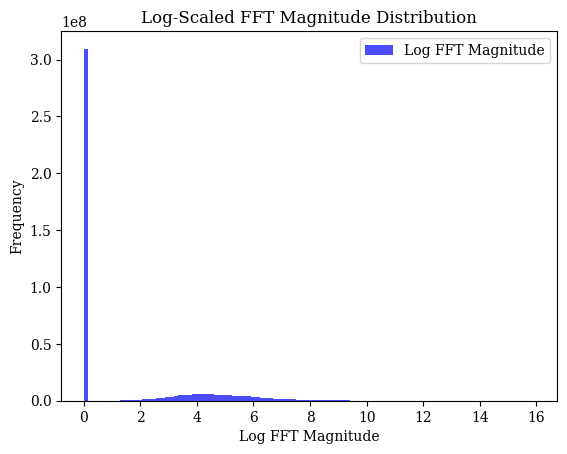

In [ ]:
import matplotlib.pyplot as plt
import importlib
from src import data_and_FFT

# Force reload of the module
importlib.reload(data_and_FFT)

# Now import the class or functions
from src.data_and_FFT import EEGDataset, visualize_eeg, visualize_fft, custom_collate


def visualize_fft_distribution(dataloader, num_batches=10):
    fft_magnitudes = []

    # Collect FFT data from a few batches
    for i, batch in enumerate(dataloader):
        if batch is None:
            print(f"Batch {i} is None. Skipping...")
            continue  # Skip invalid batches
        _, fft_data, _ = batch
        fft_magnitudes.append(fft_data.view(-1))  # Flatten and store FFT values

        if i == num_batches - 1:
            "Break called"
            break

    # Concatenate all FFT values and plot distribution
    fft_magnitudes = torch.cat(fft_magnitudes).cpu().numpy()

    print(f"Total zero elements in FFT: {(fft_magnitudes == 0).sum()}")
    print(f"Total NaN elements in FFT: {torch.isnan(torch.tensor(fft_magnitudes)).sum()}")


    plt.figure(figsize=(10, 6))
    plt.hist(fft_magnitudes, bins=100, alpha=0.7, color='blue', label='FFT Magnitude Distribution')
    plt.xlabel('FFT Magnitude')
    plt.ylabel('Frequency')
    plt.title('Distribution of FFT Magnitudes Across EEG Samples')
    plt.legend()
    plt.show()

    plt.hist(np.log1p(fft_magnitudes), bins=100, alpha=0.7, color='blue', label='Log FFT Magnitude')
    plt.xlabel('Log FFT Magnitude')
    plt.ylabel('Frequency')
    plt.title('Log-Scaled FFT Magnitude Distribution')
    plt.legend()
    plt.show()


# Test on a few batches to inspect variability
visualize_fft_distribution(dataloader, num_batches=30)


In [ ]:
from google.colab import auth
auth.authenticate_user()


# Tokenizer

In [ ]:
from src.vqvae.train import train, validate
from src.vqvae.data import EEGDataset, ToPatches
from torch.optim import AdamW
import torch

# --- Hyperparameters ---
stride = 150
batch_size = 4
num_workers = 4
num_epochs = 7
lr = 1e-4
lr_scheduler_step_size = 1
lr_scheduler_gamma = 0.9
accumulation_steps = 2

model_name = "2025_VQVAE_v1"
codebook_size = 1024
emb_dim = 64

# --- Dataset and Loader ---
transform_to_patches = ToPatches(patch_size=200, stride=stride)
eeg_dataset = EEGDataset(bucket_name=BUCKET_NAME, blob_prefix="train_eegs_HMS_processed",
                         transform=transform_to_patches)
train_size = int(0.8 * len(eeg_dataset))
valid_size = len(eeg_dataset) - train_size
train_dataset, valid_dataset = random_split(eeg_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# --- Model, Optimizer, Scheduler ---
model_class = globals()[model_name]
model = model_class(codebook_size=codebook_size, emb_dim=emb_dim)
model.to(device)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)

loss_function = partial(fft_masked_mse_loss, phase_start_batch=200, phase_end_batch=400)

# --- Train and Validate ---
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    avg_loss = train(model, train_loader, optimizer, loss_function, device,
                     scheduler=scheduler, accum_steps=accumulation_steps)
    print(f"Train Loss: {avg_loss:.4f}")
    val_loss = validate(model, valid_loader, loss_function, device)
    print(f"Validation Loss: {val_loss:.4f}")
#
